<a href="https://colab.research.google.com/github/gdoteof/neuralnet_stuff/blob/master/kaggle_whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install fast.ai dependencies.  

Here you want to make sure you have the gpu runtime selected.

![alt text](https://i.imgur.com/tCvtjwC.png)

The below will download and run a script to install fast.ai dependencies.

In [1]:
  !curl https://raw.githubusercontent.com/fastai/course-v3/master/docs/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   1862      0 --:--:-- --:--:-- --:--:--  1862
    100% |████████████████████████████████| 5.7MB 5.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62e8e000 @  0x7fa4062cb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2809, done.
remote: Total 2809 (delta 0), re

In [0]:
import sys
from fastai import *
from fastai.vision import *

###Check GPU

The following should output:


```
1.0.0
True
True```



In [3]:

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.0.0
True
True


###(Optional) Connect Google Drive

Go the the URL, give permissions on your google account, and copy the code in the box that is presented when you run the following code.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
BASE = "/content/drive/My Drive/ai/whales"

## The rest below on needs to be run once.

###Download data from Kaggle

Generate an API Token from Kaggle.  They will give you a file called kaggle.json.  Inside that file there are two values you need to fill in for `KAGGLE_USERNAME` and `KAGGLE_KEY`

In [0]:
!KAGGLE_USERNAME=gdoteof KAGGLE_KEY=1xxxxxxxxxxxxxxxxxxxxxxxxxx2 kaggle competitions download -c humpback-whale-identification


###Alright, now let's move it all to our google drive.  

In [0]:
!mkdir -p "{BASE}/train"

In [0]:
!mv test.zip train.zip train.csv "{BASE}"

In [0]:
!echo {BASE}

/content/drive/My Drive/ai/whales


In [0]:
!unzip "{BASE}"/train.zip -d "{BASE}/train"

In [0]:
!mkdir -p "{BASE}/test"

In [0]:
!unzip "{BASE}"/test.zip -d "{BASE}/test"

##Build our databunch!

First we set up some meta-parameters (size of the input image to the net and the batch size)

In [0]:
!ls "{BASE}"

models	test  test.zip	train  train.csv  train.zip


In [0]:
#ws means "with separation".  
#we are running into an issue where there are classes in the validation set but not training.
#this was going unnoticed before, but checks later are catching it
from fastai.torch_core import *
from fastai.basic_data import *
from fastai.data_block import *
from sklearn.model_selection import train_test_split


def create_from_ll(lls:LabelLists, bs:int=64, ds_tfms:Optional[TfmList]=None,
            num_workers:int=defaults.cpus, tfms:Optional[Collection[Callable]]=None, device:torch.device=None,
            test:Optional[PathOrStr]=None, collate_fn:Callable=data_collate, size:int=None, no_check:bool=False, **kwargs)->'ImageDataBunch':
    "Create an `ImageDataBunch` from `LabelLists` `lls` with potential `ds_tfms`."
    lls = lls.transform(tfms=ds_tfms, size=size, **kwargs)
    if test is not None: lls.add_test_folder(test)
    return lls.databunch(bs=bs, tfms=tfms, num_workers=num_workers, collate_fn=collate_fn, device=device, no_check=no_check)

 
  
def from_df_ws(path:PathOrStr, df:pd.DataFrame, folder:PathOrStr='.', sep=None, valid_pct:float=0.2,
                fn_col:IntsOrStrs=0, label_col:IntsOrStrs=1, suffix:str='',
                **kwargs:Any)->'ImageDataBunch':
  "Create from a `DataFrame` `df`."

  "Split the data set"
  df_train, df_valid = train_test_split(df, test_size=valid_pct, random_state=420)
  
  "find all the stuff in valid thats not in train"
  df_diff  = df_valid[~df_valid["Id"].isin(df_train["Id"])]
  
  "take that stuff out of valid"
  df_valid = df_valid[~df_valid["Id"].isin(df_diff["Id"])]

  train_iil = ImageItemList.from_df(df_train, path=path, folder=folder, suffix=suffix, cols=fn_col)
  valid_iil = ImageItemList.from_df(df_valid, path=path, folder=folder, suffix=suffix, cols=fn_col)

  src = (ItemLists(path, train_iil, valid_iil)
            .label_from_df(sep=sep, cols=label_col)) 

  return ImageDataBunch.create_from_ll(src, **kwargs)


def from_csv_ws(path:PathOrStr, folder:PathOrStr='.', sep=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2,
            fn_col:int=0, label_col:int=1, suffix:str='',
            header:Optional[Union[int,str]]='infer', **kwargs:Any)->'ImageDataBunch':
        "Create from a csv file in `path/csv_labels`."
        path = Path(path)
        df = pd.read_csv(path/csv_labels, header=header)
        return from_df_ws(path, df, folder=folder, sep=sep, valid_pct=valid_pct,
                fn_col=fn_col, label_col=label_col, suffix=suffix, **kwargs)
      


In [0]:
sz=128
bs=512  #6.2gb usage
bs=768
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)
data = from_csv_ws(path=BASE, folder=f'train', csv_labels="train.csv", ds_tfms=tfms, bs=bs, size=sz)

In [0]:
"Why can't I do this?"
save(data)
data=load('tmp')

NameError: ignored

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


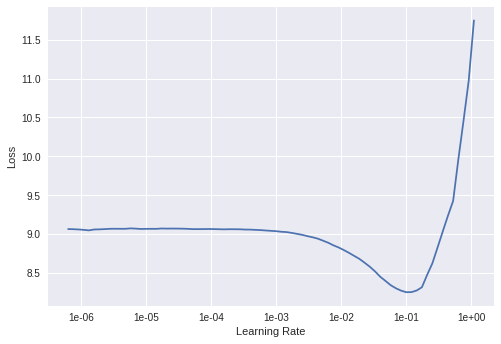

In [0]:
learn.recorder.plot()

In [0]:
"i guess we don't set learning rate anymore?"

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate
1,8.569375,8.106207,0.806758
2,7.396843,5.606319,0.627429
3,6.544768,5.240096,0.599823


In [0]:
learn.save('whale-checkpoint')

In [0]:
learn.unfreeze()
learn.lr_range(slice(1e-6,1e-2))

array([1.e-06, 1.e-04, 1.e-02])

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,5.183479,4.649187,0.571776
2,5.004416,4.516306,0.563825


At this point -- I have been deleting the output because they are being flooded with `Exception Ignored` output to the point its lagging the tab.  Loss has also been dropping

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,4.765259,4.383919,0.563604
2,4.595328,4.252269,0.556316


In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,4.383812,4.195163,0.563825
2,4.214738,4.024258,0.548807


In [0]:
learn.lr_range(slice(1e-7,1e-2))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,4.001510,3.980694,0.548145
2,3.840297,3.819719,0.538869


In [0]:
learn.lr_range(slice(1e-8,1e-3))
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,error_rate
1,3.637510,3.831148,0.553224
2,3.493265,3.668150,0.529152


In [0]:
learn.save('whaleoverfit1')

In [0]:
learn.lr_range(slice(1e-9,1e-4))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,3.301567,3.728911,0.541519
2,3.167062,3.525004,0.523189


In [0]:
learn.lr_range(slice(1e-9,1e-4))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,3.005531,3.622818,0.528048
2,2.900909,3.449982,0.512588


In [0]:
learn.save('whaleoverfit2')

In [0]:
learn.lr_range(slice(1e-9,1e-4))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,2.750777,3.605768,0.539973
2,2.638514,3.381904,0.507288


In [0]:
learn.save('whaleoverfit3')

In [0]:
learn.lr_range(slice(1e-9,1e-4))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,2.488919,3.567703,0.533348
2,2.404579,3.367573,0.508613


In [0]:
learn.save('whaleoverfit4')

In [0]:
learn.lr_range(slice(1e-9,1e-3))
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,2.281792,3.468150,0.524072
2,2.218921,3.355711,0.506405


In [1]:
data.export()

NameError: ignored